In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
import pandas as pd
import string
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install morfeusz2
import morfeusz2
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Check for GPU availability and set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.6 MB/s eta 0:00:0000:0100:01
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using device: cuda


# Wczytanie danych
Będziemy pracować na zbiorze danych zwierających opinie z allegro. Datasety zawierają opinie wraz z przyporządkowaną liczbą gwiazdek (1-5). Każda opinia zawiera przyjnamniej 50 znaków. Będziemy trenować nasze modele na zestawie treningowym i sprawdzać działanie na zestwie do ewaluacji.
Zacznijmy od wczytania danych i wizualizacji

In [2]:
import pandas as pd

train_df = pd.read_csv('/kaggle/input/datapjn/datasetKLEJ/train.tsv', delimiter='\t')
dev_df = pd.read_csv('/kaggle/input/datapjn/datasetKLEJ/dev.tsv', delimiter='\t')

# convert rating to ints
train_df['rating'] = train_df['rating'].astype(int)
dev_df['rating'] = dev_df['rating'].astype(int)

print(f"Train: {len(train_df)}")
print(train_df.head())
print(f"Dev: {len(dev_df)}")
print(dev_df.head())

Train: 9577
                                                text  rating
0  Jako do ceny dobra. Przyssawka mogłaby być lep...       3
1  Na słuchawkę czekałam spory czas a po zadzwoni...       1
2  Czajnik na pierwszy rzut oka wygląda ok, ale n...       1
3  Bardzo fajny czajnik, na pewno nie gorszy od m...       4
4  Pomysł na produkt (uchwyt na kierownicę) bardz...       2
Dev: 1002
                                                text  rating
0  Generalnie ok.  Znośna jakość dźwięku. Ale to ...       3
1  W upalne dni przyssawka staje się tak elastycz...       4
2  Według mnie statyw na początku był bardzo fajn...       1
3  Specyfikacja mówi sama za siebie i faktycznie ...       5
4  Wykonanie przeciętne . Krajalnicy nie używamy ...       3


# Wizualizacja danych
Widzimy, że zdecydoawnie największą grupę stanowią opinie z 5 gwiazdkami. Najmniej jest opinii z 2 i 3 gwiazdkami co może stanowić pewien problem, tym bardziej że są to zazwyczaj "trudniejsze" przykłady do klasyfikacji niż opinie na 5 lub 1 gwiazdkę.

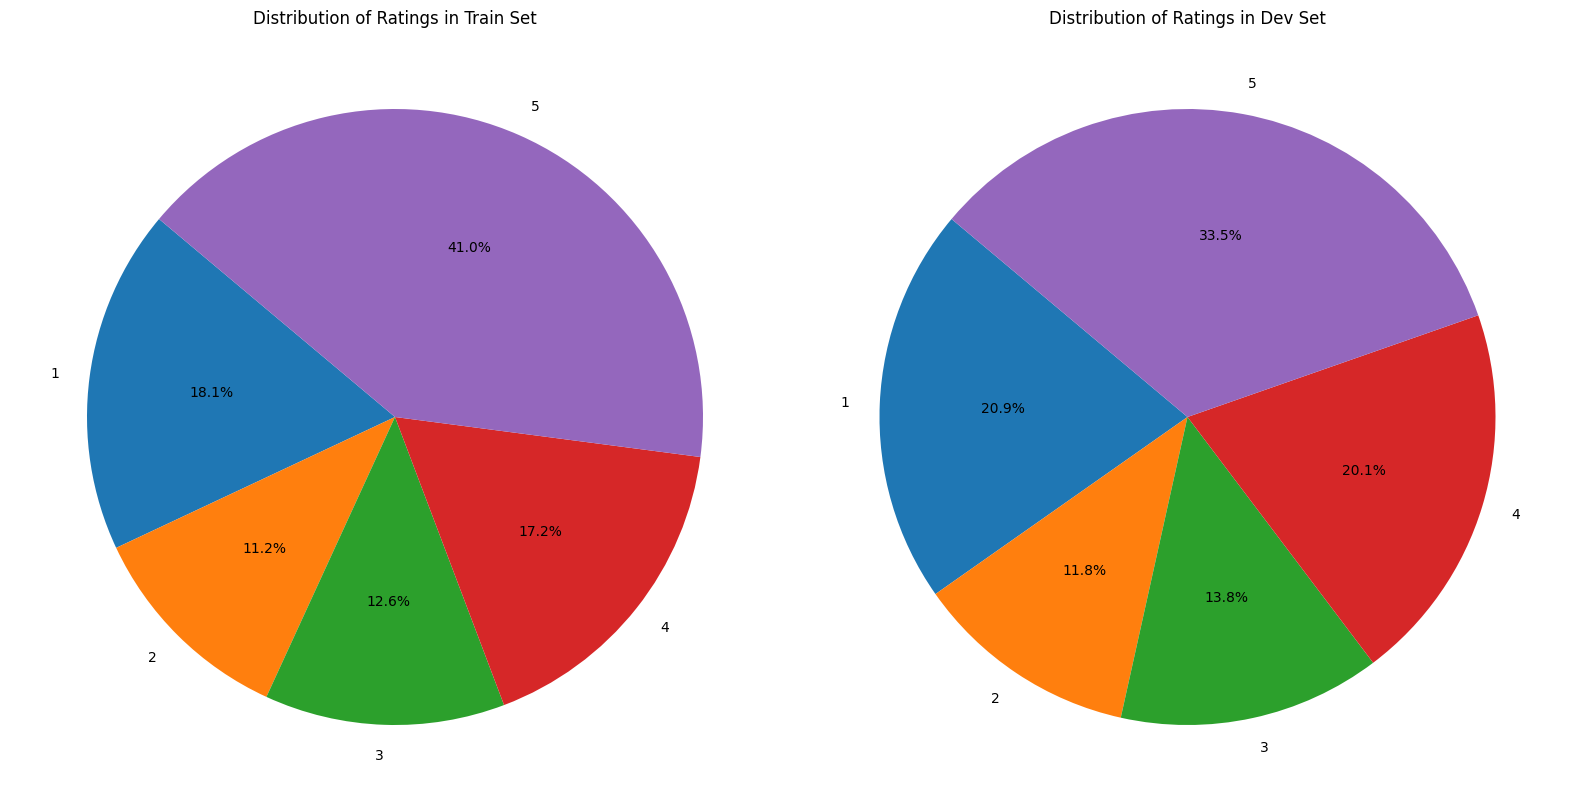

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of entries for each rating
train_rating_counts = train_df['rating'].value_counts().sort_index()
dev_rating_counts = dev_df['rating'].value_counts().sort_index()

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot pie chart for train set
axs[0].pie(train_rating_counts, labels=train_rating_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Ratings in Train Set')

# Plot pie chart for dev set
axs[1].pie(dev_rating_counts, labels=dev_rating_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Distribution of Ratings in Dev Set')

# Display the charts
plt.tight_layout()
plt.show()


# Metryki
Do sprawdzania skuteczności będziemy używać accurancy oraz AR score zaproponowanego przez autorów datasetu. Jest to bardziej sensowna metryka niż zwykłe accurancy, bo uwzględnia jak bardzo się pomylimy.
Przykładowo jeżeli opinię z oceną "5" zakwalifikujemy na "4" to jest to dużo lepiej niż gdybyśmy uznali ją np. za "1"

In [122]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


def ar_score(y_true, y_pred):
    ds = pd.DataFrame({
        'y_true': (y_true - 1.0)/4.0,
        'y_pred': (y_pred - 1.0)/4.0,
    })
    wmae = ds \
        .groupby('y_true') \
        .apply(lambda df: mean_absolute_error(df['y_true'], df['y_pred'])) \
        .mean()

    return 100*(1 - wmae)

In [5]:
# Map numerical labels to sentiment categories
def label_to_sentiment(label):
    if label in [1.0, 2.0]:
        return 'negative'
    elif label == 3.0:
        return 'neutral'
    else:  # 4.0 and 5.0
        return 'positive'

# 3 różne podejścia do czyszczenia danych
Sprawdzimy jak rózne sposoby przetwarzania tekstu wpłyną na skuteczność przewidywań. W pierwszej wersji stosujemy podstawowe operacje do przetwarzania tekstu, w drugiej dodatkowo usuwamy stopwordy które często pojawiają się w jęxyku polskim, a w trzeciej wersji dodatkowo używamy lemmatizera Morfeusz

In [6]:
# Basic Text Cleaning
def basic_text_cleaning(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [10]:
with open('/kaggle/input/datapjn/datasetKLEJ/polish.stopwords.txt', 'r') as f:
    stopwords_list = f.read().splitlines()

In [21]:
#  Basic Text Cleaning + Removing Stopwords
def remove_stopwords(text):
    words = basic_text_cleaning(text)
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(words)


In [22]:
# Basic Text Cleaning + Removing Stopwords + morfeusz Lemmatization
def lemmatize_text(text, morf):
    words = remove_stopwords(text)
    words = word_tokenize(text)
    words = [morf.analyse(word)[0][2][1].split(':')[0] for word in words]
    return ' '.join(words)

Sprawdźmy przykłady po przetworzeniu tekstu różnymi metodamu

In [23]:
morf = morfeusz2.Morfeusz()

# Apply data cleaning methods
train_df['text_basic_clean'] = train_df['text'].apply(basic_text_cleaning)
dev_df['text_basic_clean'] = dev_df['text'].apply(basic_text_cleaning)

train_df['text_no_stopwords'] = train_df['text_basic_clean'].apply(lambda x: remove_stopwords(x))
dev_df['text_no_stopwords'] = dev_df['text_basic_clean'].apply(lambda x: remove_stopwords(x))

train_df['text_lemmatized'] = train_df['text_no_stopwords'].apply(lambda x: lemmatize_text(x, morf))
dev_df['text_lemmatized'] = dev_df['text_no_stopwords'].apply(lambda x: lemmatize_text(x, morf))

print(train_df.head())
print(dev_df.head())

                                                text  rating  \
0  Jako do ceny dobra. Przyssawka mogłaby być lep...       3   
1  Na słuchawkę czekałam spory czas a po zadzwoni...       1   
2  Czajnik na pierwszy rzut oka wygląda ok, ale n...       1   
3  Bardzo fajny czajnik, na pewno nie gorszy od m...       4   
4  Pomysł na produkt (uchwyt na kierownicę) bardz...       2   

                                    text_basic_clean  \
0  jako do ceny dobra przyssawka mogłaby być leps...   
1  na słuchawkę czekałam spory czas a po zadzwoni...   
2  czajnik na pierwszy rzut oka wygląda ok ale ni...   
3  bardzo fajny czajnik na pewno nie gorszy od ma...   
4  pomysł na produkt uchwyt na kierownicę bardzo ...   

                                   text_no_stopwords  \
0  ceny dobra przyssawka mogłaby lepsza miesiącac...   
1  słuchawkę czekałam spory czas zadzwonieniu oka...   
2  czajnik pierwszy rzut oka wygląda ok polecam w...   
3  fajny czajnik pewno gorszy markowych tefal bos...  

# Naive Bayes Classifier
Pierwszym podejściem jakie zastosujemy będzie NBC.

In [135]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.word_counts = {}
        self.vocabulary = set()
        self.class_word_counts = {}

    def fit(self, texts, labels):
        total_count = len(labels)
        label_counts = Counter(labels)

        # Calculate class priors
        for label, count in label_counts.items():
            self.class_priors[label] = count / total_count
            self.word_counts[label] = defaultdict(int)
            self.class_word_counts[label] = 0

        # Count words per class
        for text, label in zip(texts, labels):
            words = text.split()
            for word in words:
                self.vocabulary.add(word)
                self.word_counts[label][word] += 1
                self.class_word_counts[label] += 1

    def predict(self, texts):
        predictions = []
        for text in texts:
            words = text.split()
            class_scores = {}
            for label in self.class_priors.keys():
                # Initialize with the class prior
                class_scores[label] = self.class_priors[label]
                # Multiply by the likelihood of each word in the text
                for word in words:
                    word_count = self.word_counts[label].get(word, 0) + 1  # Add-one smoothing
                    total_words = self.class_word_counts[label] + len(self.vocabulary)
                    class_scores[label] *= word_count / total_words
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions

# Train and test the classifier using different cleaning methods
def train_and_evaluate(train_texts, train_labels, dev_texts, dev_labels):
    classifier = NaiveBayesClassifier()
    classifier.fit(train_texts, train_labels)
    predictions = classifier.predict(dev_texts)
    accuracy = (predictions == dev_labels).mean()
    arscore = ar_score(np.array(dev_labels), np.array(predictions))
    # Calculate sentiment accuracy
    sentiment_predictions = [label_to_sentiment(p) for p in predictions]
    sentiment_true_labels = [label_to_sentiment(t) for t in dev_labels]
    sentiment_accuracy = (np.array(sentiment_predictions) == np.array(sentiment_true_labels)).mean()

    return accuracy*100, arscore, sentiment_accuracy*100

# Evaluate different cleaning methods
results = {}

# Raw Text
accuracy, arscore, sentiment_accuracy = train_and_evaluate(train_df['text'], train_df['rating'], dev_df['text'], dev_df['rating'])
results['Raw Text'] = (accuracy, arscore, sentiment_accuracy)
print(f"Raw Text accurancy: {accuracy:.2f}%")
print(f"Raw Text sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Raw Text arscore: {arscore:.2f}")
print(f"==============================================================")

# Basic Cleaning
accuracy, arscore, sentiment_accuracy  = train_and_evaluate(train_df['text_basic_clean'], train_df['rating'], dev_df['text_basic_clean'], dev_df['rating'])
results['Basic Cleaning'] = (accuracy, arscore, sentiment_accuracy)
print(f"Basic Cleaning accurancy: {accuracy:.2f}%")
print(f"Basic Cleaning sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Basic Cleaning arscore: {arscore:.2f}")
print(f"==============================================================")

# No Stopwords
accuracy, arscore, sentiment_accuracy = train_and_evaluate(train_df['text_no_stopwords'], train_df['rating'], dev_df['text_no_stopwords'], dev_df['rating'])
results['No Stopwords'] = (accuracy, arscore, sentiment_accuracy)
print(f"No Stopwords accurancy: {accuracy:.2f}%")
print(f"No Stopwords sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"No Stopwords arscore: {arscore:.2f}")
print(f"==============================================================")

# Lemmatization
accuracy, arscore, sentiment_accuracy = train_and_evaluate(train_df['text_lemmatized'], train_df['rating'], dev_df['text_lemmatized'], dev_df['rating'])
results['Lemmatization'] = (accuracy, arscore, sentiment_accuracy)
print(f"Lemmatization accurancy: {accuracy:.2f}%")
print(f"Lemmatization sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Lemmatization arscore: {arscore:.2f}")
print(f"==============================================================")


Raw Text accurancy: 41.92%
Raw Text sentiment accuracy: 57.29%
Raw Text arscore: 69.95
Basic Cleaning accurancy: 46.91%
Basic Cleaning sentiment accuracy: 64.77%
Basic Cleaning arscore: 73.82
No Stopwords accurancy: 48.90%
No Stopwords sentiment accuracy: 70.36%
No Stopwords arscore: 74.06
Lemmatization accurancy: 46.91%
Lemmatization sentiment accuracy: 67.56%
Lemmatization arscore: 72.08


# Wizualizacja wyników


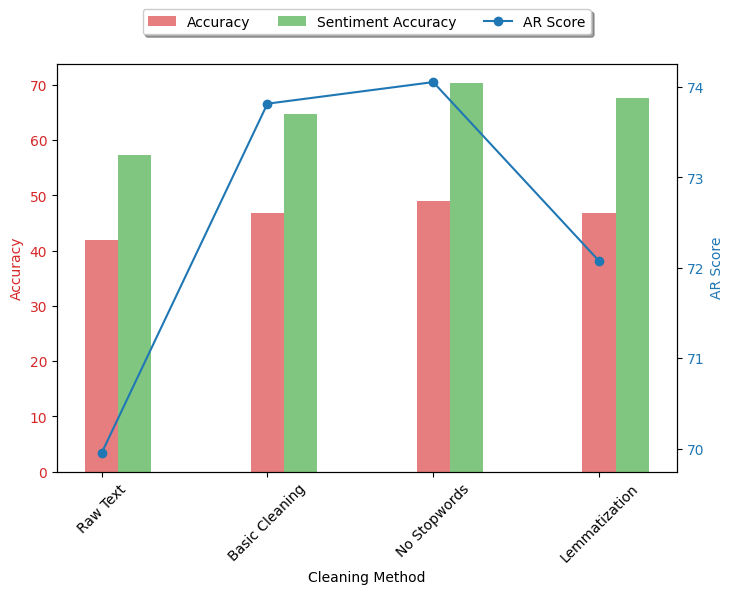

In [136]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]
sentiment_accuracies = [results[method][2] for method in methods]  # Assuming this is your sentiment accuracy data

x = range(len(methods))

fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plot Accuracy
color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)  # Rotate for better readability if needed

# Plot AR Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

# Adjust x position for sentiment_accuracy bars
x_sentiment = [i + 0.2 for i in x]  # Offset by 0.2

# Plot Sentiment Accuracy as bars
color = 'tab:green'  # Choose a different color for sentiment accuracy
ax1.bar(x_sentiment, sentiment_accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Sentiment Accuracy')

# Legend
# Place the legend at the bottom of the plot
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=3)

# Adjust the bottom of the subplots to fit the legend
fig.subplots_adjust(bottom=0.2)

plt.show()

# Inne podejście - prosta sieć neuronowa

In [137]:
# Define a simple CNN for text classification
class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Tworzenie datasetów w formie dostosowanej do NN

In [138]:
# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Simple tokenizer function
def simple_tokenizer(text):
    return word_tokenize(text.lower())

# Function to create data loaders
def create_data_loaders(train_texts, train_labels, dev_texts, dev_labels, vectorizer):
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_dev = vectorizer.transform(dev_texts).toarray()

    # Convert texts to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_dev = torch.tensor(X_dev, dtype=torch.float32)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(train_labels), dtype=torch.long)
    y_dev = torch.tensor(label_encoder.transform(dev_labels), dtype=torch.long)

    # Create datasets and data loaders
    train_dataset = TextDataset(X_train, y_train)
    dev_dataset = TextDataset(X_dev, y_dev)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

    return train_loader, dev_loader, X_train.shape[1]

# Pętla treningowa

In [145]:
import torch

# Function to train and evaluate the model
def train_and_evaluate(train_loader, dev_loader, input_size, num_epochs=20):
    model = SimpleNN(num_features=input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        predictions = []
        ground_truth = []
        for texts, labels in dev_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy() + 1) #back to label 1-5
            ground_truth.extend(labels.cpu().numpy() + 1)

    sentiment_accuracy = 100 * sum(1 for a,b in zip(predictions,ground_truth) if label_to_sentiment(a) == label_to_sentiment(b)) / total
    accuracy = 100 * correct / total
    return accuracy, predictions, sentiment_accuracy


# Wyniki
Widzimy, że generalnie wyniki sieci neuronowej są bardzo zbliżone niezależnie od wybranej metody przetwarzania tekstu. Niemniej jednak są one wyraźnie wyższe niż w przybadku NBC zarówno pod względem accuracy jak i ar_score

In [146]:
# Vectorizers
vectorizer_raw = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_basic = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_stopwords = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_lemmatized = CountVectorizer(tokenizer=simple_tokenizer)

# Training and evaluation
results = {}

# Raw Text
train_loader, dev_loader, input_size = create_data_loaders(train_df['text'], train_df['rating'], dev_df['text'], dev_df['rating'], vectorizer_basic)
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Raw Text'] = (accuracy, arscore, sentiment_accuracy)

print(f"==============================================================")
print(f"Raw Text accurancy: {accuracy:.2f}%")
print(f"Raw Text sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Raw Text arscore: {arscore:.2f}")
print(f"==============================================================")

Epoch 1/20, Loss: 1.1697778701782227
Epoch 2/20, Loss: 0.932837188243866
Epoch 3/20, Loss: 0.807358980178833
Epoch 4/20, Loss: 0.483184814453125
Epoch 5/20, Loss: 0.06605864316225052
Epoch 6/20, Loss: 0.02129543572664261
Epoch 7/20, Loss: 0.011727655306458473
Epoch 8/20, Loss: 0.016397662460803986
Epoch 9/20, Loss: 0.003477742662653327
Epoch 10/20, Loss: 0.0021300914231687784
Epoch 11/20, Loss: 0.002155332826077938
Epoch 12/20, Loss: 0.0009914508555084467
Epoch 13/20, Loss: 0.027645519003272057
Epoch 14/20, Loss: 0.0071859764866530895
Epoch 15/20, Loss: 0.0014277007430791855
Epoch 16/20, Loss: 0.02134787291288376
Epoch 17/20, Loss: 0.056554775685071945
Epoch 18/20, Loss: 0.015078885480761528
Epoch 19/20, Loss: 0.0008990778005681932
Epoch 20/20, Loss: 0.008164100348949432
Raw Text accurancy: 50.40%
Raw Text sentiment accuracy: 75.05%
Raw Text arscore: 82.74


In [147]:
# Basic Cleaning
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_basic_clean'], train_df['rating'], dev_df['text_basic_clean'], dev_df['rating'], vectorizer_basic)
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Basic Cleaning'] = (accuracy, arscore, sentiment_accuracy)

print(f"==============================================================")
print(f"Basic Cleaning accurancy: {accuracy:.2f}%")
print(f"Basic Cleaning sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Basic Cleaning arscore: {arscore:.2f}")
print(f"==============================================================")

Epoch 1/20, Loss: 1.0948156118392944
Epoch 2/20, Loss: 1.615142583847046
Epoch 3/20, Loss: 0.48955944180488586
Epoch 4/20, Loss: 0.3982868790626526
Epoch 5/20, Loss: 0.19141046702861786
Epoch 6/20, Loss: 0.23619167506694794
Epoch 7/20, Loss: 0.004884195514023304
Epoch 8/20, Loss: 0.3412334620952606
Epoch 9/20, Loss: 0.006029042415320873
Epoch 10/20, Loss: 0.006856075953692198
Epoch 11/20, Loss: 0.013428794220089912
Epoch 12/20, Loss: 0.001146997674368322
Epoch 13/20, Loss: 0.013665248639881611
Epoch 14/20, Loss: 0.007655415218323469
Epoch 15/20, Loss: 0.002674760762602091
Epoch 16/20, Loss: 0.025946687906980515
Epoch 17/20, Loss: 0.0025002053007483482
Epoch 18/20, Loss: 0.004453444853425026
Epoch 19/20, Loss: 0.004800548776984215
Epoch 20/20, Loss: 0.01543623860925436
Basic Cleaning accurancy: 50.40%
Basic Cleaning sentiment accuracy: 73.55%
Basic Cleaning arscore: 83.39


In [148]:
# No Stopwords
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_no_stopwords'], train_df['rating'], dev_df['text_no_stopwords'], dev_df['rating'], vectorizer_stopwords)
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['No Stopwords'] = (accuracy, arscore, sentiment_accuracy)

print(f"==============================================================")
print(f"No Stopwords accurancy: {accuracy:.2f}%")
print(f"No Stopwords sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"No Stopwords arscore: {arscore:.2f}")
print(f"==============================================================")

Epoch 1/20, Loss: 1.5348353385925293
Epoch 2/20, Loss: 0.3383121192455292
Epoch 3/20, Loss: 0.20927339792251587
Epoch 4/20, Loss: 0.015089418739080429
Epoch 5/20, Loss: 0.11512912809848785
Epoch 6/20, Loss: 0.027033435180783272
Epoch 7/20, Loss: 0.0297445859760046
Epoch 8/20, Loss: 0.0073437774553895
Epoch 9/20, Loss: 0.00949289370328188
Epoch 10/20, Loss: 0.001500630984082818
Epoch 11/20, Loss: 0.009564211592078209
Epoch 12/20, Loss: 0.00039060917333699763
Epoch 13/20, Loss: 0.012406443245708942
Epoch 14/20, Loss: 0.013327661901712418
Epoch 15/20, Loss: 0.010297480039298534
Epoch 16/20, Loss: 0.012277825735509396
Epoch 17/20, Loss: 0.02852734923362732
Epoch 18/20, Loss: 4.1970259189838544e-05
Epoch 19/20, Loss: 0.3040754199028015
Epoch 20/20, Loss: 0.01887279935181141
No Stopwords accurancy: 53.39%
No Stopwords sentiment accuracy: 70.36%
No Stopwords arscore: 82.33


In [149]:
# Lemmatization
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_lemmatized'], train_df['rating'], dev_df['text_lemmatized'], dev_df['rating'], vectorizer_lemmatized)
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Lemmatization'] = (accuracy, arscore, sentiment_accuracy)

print(f"==============================================================")
print(f"Lemmatization accurancy: {accuracy:.2f}%")
print(f"Lemmatization sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Lemmatization arscore: {arscore:.2f}")
print(f"==============================================================")

Epoch 1/20, Loss: 1.3056676387786865
Epoch 2/20, Loss: 0.5688504576683044
Epoch 3/20, Loss: 0.8602450489997864
Epoch 4/20, Loss: 0.14555591344833374
Epoch 5/20, Loss: 0.4975818395614624
Epoch 6/20, Loss: 0.4000197649002075
Epoch 7/20, Loss: 0.009701350703835487
Epoch 8/20, Loss: 0.020892536267638206
Epoch 9/20, Loss: 0.0005543340812437236
Epoch 10/20, Loss: 0.029692016541957855
Epoch 11/20, Loss: 0.003032904816791415
Epoch 12/20, Loss: 0.01924300193786621
Epoch 13/20, Loss: 0.002197212539613247
Epoch 14/20, Loss: 0.0038876309990882874
Epoch 15/20, Loss: 0.005119506269693375
Epoch 16/20, Loss: 0.5363091230392456
Epoch 17/20, Loss: 0.07838212698698044
Epoch 18/20, Loss: 0.43713176250457764
Epoch 19/20, Loss: 0.32791265845298767
Epoch 20/20, Loss: 0.0051458608359098434
Lemmatization accurancy: 47.60%
Lemmatization sentiment accuracy: 69.56%
Lemmatization arscore: 78.79


# Wizualizacja wyników

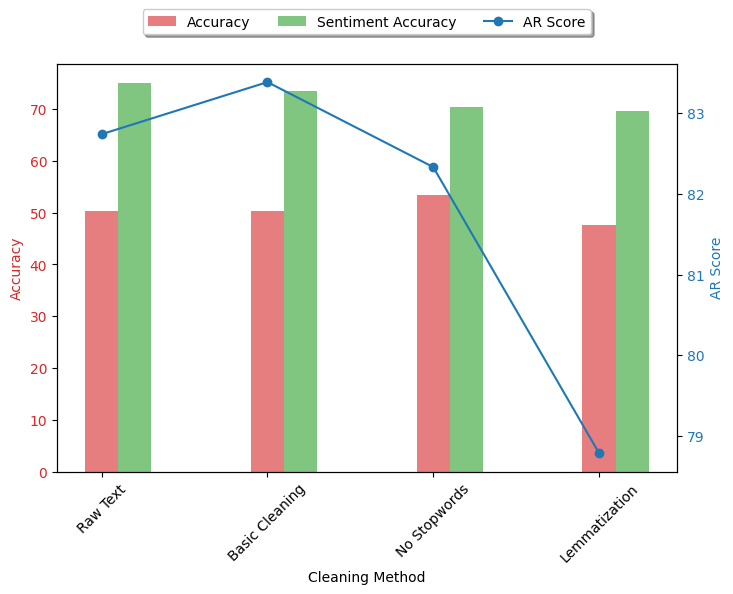

In [150]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]
sentiment_accuracies = [results[method][2] for method in methods]  # Assuming this is your sentiment accuracy data

x = range(len(methods))

fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plot Accuracy
color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)  # Rotate for better readability if needed

# Plot AR Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

# Adjust x position for sentiment_accuracy bars
x_sentiment = [i + 0.2 for i in x]  # Offset by 0.2

# Plot Sentiment Accuracy as bars
color = 'tab:green'  # Choose a different color for sentiment accuracy
ax1.bar(x_sentiment, sentiment_accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Sentiment Accuracy')

# Legend
# Place the legend at the bottom of the plot
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=3)

# Adjust the bottom of the subplots to fit the legend
fig.subplots_adjust(bottom=0.2)

plt.show()

# Inne podejścia - regresja liniowa i SVM
Sprawdźmy także jak radzą sobie inne klasyczne meodele wykorzystywane do klasyfikacji - regresja liniowa oraz SVM

**1) Regresja liniowa**

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

vectorizer = CountVectorizer(tokenizer=simple_tokenizer)

# Evaluate different cleaning methods
results = {}

# Raw Text
X_train = vectorizer.fit_transform(train_df['text'])
X_dev = vectorizer.transform(dev_df['text'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Raw Text'] = (accuracy, arscore, sentiment_accuracy)
print(f"Raw Text accurancy: {accuracy:.2f}%")
print(f"Raw Text sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Raw Text arscore: {arscore:.2f}")
print(f"==============================================================")

# Basic Cleaning
X_train = vectorizer.fit_transform(train_df['text_basic_clean'])
X_dev = vectorizer.transform(dev_df['text_basic_clean'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Basic Cleaning'] = (accuracy, arscore, sentiment_accuracy)
print(f"Basic Cleaning accurancy: {accuracy:.2f}%")
print(f"Basic Cleaning sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Basic Cleaning arscore: {arscore:.2f}")
print(f"==============================================================")

# No Stopwords
X_train = vectorizer.fit_transform(train_df['text_no_stopwords'])
X_dev = vectorizer.transform(dev_df['text_no_stopwords'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['No Stopwords'] = (accuracy, arscore, sentiment_accuracy)
print(f"No Stopwords accurancy: {accuracy:.2f}%")
print(f"No Stopwords sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"No Stopwords arscore: {arscore:.2f}")
print(f"==============================================================")

# Lemmatization
X_train = vectorizer.fit_transform(train_df['text_lemmatized'])
X_dev = vectorizer.transform(dev_df['text_lemmatized'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Lemmatization'] = (accuracy, arscore, sentiment_accuracy)
print(f"Lemmatization accurancy: {accuracy:.2f}%")
print(f"Lemmatization sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Lemmatization arscore: {arscore:.2f}")
print(f"==============================================================")


Raw Text accurancy: 54.09%
Raw Text sentiment accuracy: 72.46%
Raw Text arscore: 79.51
Basic Cleaning accurancy: 52.99%
Basic Cleaning sentiment accuracy: 71.36%
Basic Cleaning arscore: 78.63
No Stopwords accurancy: 51.80%
No Stopwords sentiment accuracy: 70.96%
No Stopwords arscore: 77.49
Lemmatization accurancy: 50.40%
Lemmatization sentiment accuracy: 72.46%
Lemmatization arscore: 77.67


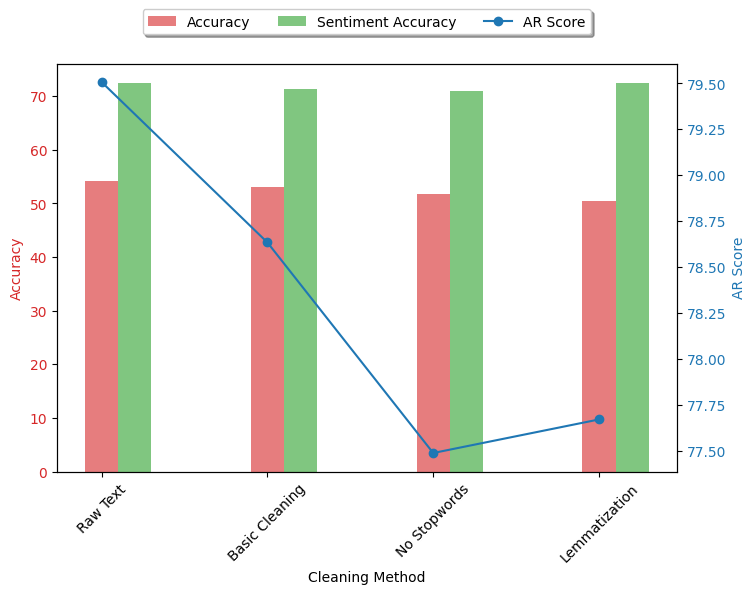

In [152]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]
sentiment_accuracies = [results[method][2] for method in methods]  # Assuming this is your sentiment accuracy data

x = range(len(methods))

fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plot Accuracy
color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)  # Rotate for better readability if needed

# Plot AR Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

# Adjust x position for sentiment_accuracy bars
x_sentiment = [i + 0.2 for i in x]  # Offset by 0.2

# Plot Sentiment Accuracy as bars
color = 'tab:green'  # Choose a different color for sentiment accuracy
ax1.bar(x_sentiment, sentiment_accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Sentiment Accuracy')

# Legend
# Place the legend at the bottom of the plot
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=3)

# Adjust the bottom of the subplots to fit the legend
fig.subplots_adjust(bottom=0.2)

plt.show()

**2) SVM**

In [155]:
from sklearn.svm import LinearSVC

# Evaluate different cleaning methods
results = {}

# Raw Text
X_train = vectorizer.fit_transform(train_df['text'])
X_dev = vectorizer.transform(dev_df['text'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Raw Text'] = (accuracy, arscore, sentiment_accuracy)
print(f"Raw Text accurancy: {accuracy:.2f}%")
print(f"Raw Text sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Raw Text arscore: {arscore:.2f}")
print(f"==============================================================")

# Basic Cleaning
X_train = vectorizer.fit_transform(train_df['text_basic_clean'])
X_dev = vectorizer.transform(dev_df['text_basic_clean'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Basic Cleaning'] = (accuracy, arscore, sentiment_accuracy)
print(f"Basic Cleaning accurancy: {accuracy:.2f}%")
print(f"Basic Cleaning sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Basic Cleaning arscore: {arscore:.2f}")
print(f"==============================================================")

# No Stopwords
X_train = vectorizer.fit_transform(train_df['text_no_stopwords'])
X_dev = vectorizer.transform(dev_df['text_no_stopwords'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['No Stopwords'] = (accuracy, arscore, sentiment_accuracy)
print(f"No Stopwords accurancy: {accuracy:.2f}%")
print(f"No Stopwords sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"No Stopwords arscore: {arscore:.2f}")
print(f"==============================================================")

# Lemmatization
X_train = vectorizer.fit_transform(train_df['text_lemmatized'])
X_dev = vectorizer.transform(dev_df['text_lemmatized'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = 100 * accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
sentiment_accuracy = 100 * sum(1 for a,b in zip(y_pred, dev_df['rating']) if label_to_sentiment(a) == label_to_sentiment(b)) / len(y_pred)
results['Lemmatization'] = (accuracy, arscore, sentiment_accuracy)
print(f"Lemmatization accurancy: {accuracy:.2f}%")
print(f"Lemmatization sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Lemmatization arscore: {arscore:.2f}")
print(f"==============================================================")

Raw Text accurancy: 52.40%
Raw Text sentiment accuracy: 71.46%
Raw Text arscore: 78.68
Basic Cleaning accurancy: 50.90%
Basic Cleaning sentiment accuracy: 69.86%
Basic Cleaning arscore: 77.82
No Stopwords accurancy: 50.30%
No Stopwords sentiment accuracy: 69.06%
No Stopwords arscore: 76.73
Lemmatization accurancy: 46.11%
Lemmatization sentiment accuracy: 68.46%
Lemmatization arscore: 75.31


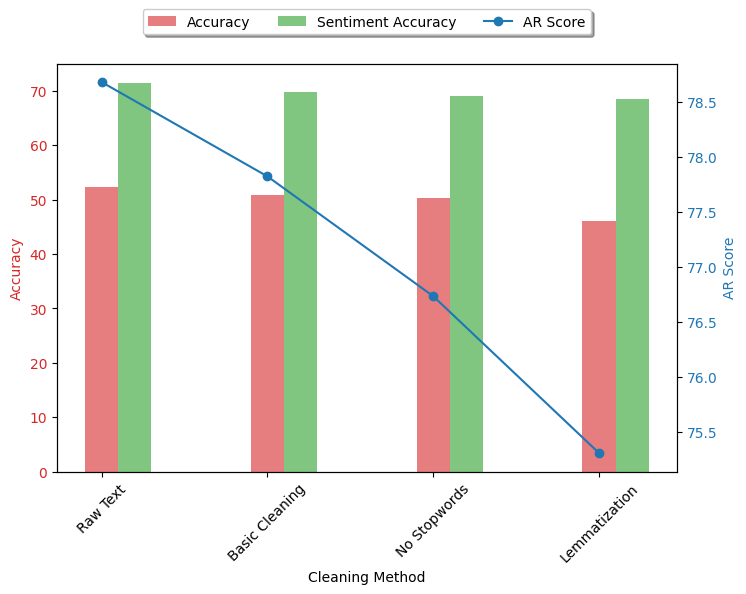

In [156]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]
sentiment_accuracies = [results[method][2] for method in methods]  # Assuming this is your sentiment accuracy data

x = range(len(methods))

fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plot Accuracy
color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)  # Rotate for better readability if needed

# Plot AR Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

# Adjust x position for sentiment_accuracy bars
x_sentiment = [i + 0.2 for i in x]  # Offset by 0.2

# Plot Sentiment Accuracy as bars
color = 'tab:green'  # Choose a different color for sentiment accuracy
ax1.bar(x_sentiment, sentiment_accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Sentiment Accuracy')

# Legend
# Place the legend at the bottom of the plot
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=3)

# Adjust the bottom of the subplots to fit the legend
fig.subplots_adjust(bottom=0.2)

plt.show()

Widzimy, że zarówno regresja liniowa jak i SVM radzą sobie lepiej niż NBC, ale jednocześnie ar_score jest nieco niższe niż dla prostej siexi neuronowej.

# Modyfikacja sieci neuronowej - uwzględnienie dodatkowych informacji
Zarówno w negatywnych jak i pozytywnych opiniach często używane są emocjonalne słowa, aby podkreślić swoje zdanie. Użycie np. słowa "głupi" albo "beznadziejny" dosyć jednoznacznie wskazuje na negatywny wydźwięk opinii, podczas gdy słowa takie jak "świetny", "piękny" wskazują na pozytywne emocje.

Spróbujemy zatem zmodyfikować naszą wcześniejszą sieć nauronową tak aby mocniej uwzględnić takie słowa o jednoznacznym wydźwięku. Do tego celu użyjemy dwóch zestawów słów: pozytywnych oraz negatywnych. Oba zestawy liczą ok. 500 słów.

1) Podstawowa sieć działa dokładnie tak samo jak wcześniej

2) Dodatkowo dla każdej opinii zliczymy ile razy występują w niej słowa negatywne i pozytywne i obliczone na tej podstawie wartości przekażemy do osobnych sieci neuronowych

3) W ostatniej warstwie łączymy reprezentacje cech pozytywnych i negatywnych razem z reprezentacją cech przetworzonego tekstu i na tej podstawie dokonujemy klasyfikacji

Dzięki zastosowaniu takiego mechanizmu nasza sieć dalej ma informacje bezpośrednio na podstawie tekstu, ale dodatkowo otrzymuje informacje, które powinny pomóc nakierować się we właściwą stronę w przypadku wystąpienia słów o jednoznacznym charakterze pozytywnym allbo negatywnym

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import numpy as np


def calculate_sentiment_scores(text, negative_words, positive_words):
    tokens = simple_tokenizer(text)
    # "lemma" is the word without the 2 last chars
    negative_score = sum(4 for word in tokens if any(word[:-2] == neg_word[:-2] for neg_word in negative_words)) + 1
    positive_score = sum(4 for word in tokens if any(word[:-2] == pos_word[:-2] for pos_word in positive_words)) + 1
    total_words = len(tokens) + 1
    
    return negative_score / total_words, positive_score / total_words

class TextDataset(Dataset):
    def __init__(self, vectorized_texts, labels, original_texts, negative_words, positive_words):
        self.vectorized_texts = vectorized_texts
        self.labels = labels
        self.original_texts = original_texts
        self.negative_words = negative_words
        self.positive_words = positive_words
        self.scores = [calculate_sentiment_scores(text, self.negative_words, self.positive_words) for text in self.original_texts]
        
    def __len__(self):
        return len(self.vectorized_texts)

    def __getitem__(self, idx):
        vectorized_text = self.vectorized_texts[idx]
        label = self.labels[idx]
        # Calculate sentiment scores from the original text
        curr_scores = self.scores[idx]
        negative_score = curr_scores[0]
        positive_score = curr_scores[1]
        return vectorized_text, label, negative_score, positive_score

class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        # Main text features pathway
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)

        # Separate pathways for negative and positive sentiment scores
        self.negative_fc1 = nn.Linear(1, 8)
        self.negative_fc2 = nn.Linear(8, 16)
        self.positive_fc1 = nn.Linear(1, 8)
        self.positive_fc2 = nn.Linear(8, 16)

        # Final layer
        self.fc4 = nn.Linear(16 + 16 + 16, 5)  # Combining text features with negative and positive sentiment pathways

    def forward(self, x, negative_score, positive_score):
        # Main text features pathway
        negative_score = negative_score.float()
        positive_score = positive_score.float()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Negative sentiment pathway
        negative_score = torch.relu(self.negative_fc1(negative_score.unsqueeze(1)))
        negative_score = torch.relu(self.negative_fc2(negative_score))

        # Positive sentiment pathway
        positive_score = torch.relu(self.positive_fc1(positive_score.unsqueeze(1)))
        positive_score = torch.relu(self.positive_fc2(positive_score))

        # Combine the outputs from all pathways
        x = torch.cat((x, negative_score, positive_score), dim=1)
        return x


# Modify your create_data_loaders function to include the original texts
def create_data_loaders(train_texts, train_labels, dev_texts, dev_labels, vectorizer, negative_words, positive_words):
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_dev = vectorizer.transform(dev_texts).toarray()

    # Convert vectorized texts to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_dev = torch.tensor(X_dev, dtype=torch.float32)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(train_labels), dtype=torch.long)
    y_dev = torch.tensor(label_encoder.transform(dev_labels), dtype=torch.long)

    # Create datasets and data loaders
    train_dataset = TextDataset(X_train, y_train, train_texts, negative_words, positive_words)
    dev_dataset = TextDataset(X_dev, y_dev, dev_texts, negative_words, positive_words)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

    return train_loader, dev_loader, X_train.shape[1]

# Modify the training loop to use vectorized_text for the model input
# Function to train and evaluate the model
def train_and_evaluate(train_loader, dev_loader, input_size, num_epochs=20):
    model = SimpleNN(num_features=input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        trainloss = 0
        size = len(train_loader)
        for vectorized_text, labels, negative_score, positive_score in train_loader:
            vectorized_text, labels = vectorized_text.to(device), labels.to(device)
            negative_score, positive_score = negative_score.to(device), positive_score.to(device)
            optimizer.zero_grad()
            outputs = model(vectorized_text, negative_score, positive_score)
            loss = criterion(outputs, labels)
            trainloss += loss
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs} loss: {trainloss/size}")
        
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        predictions = []
        ground_truth = []
        for vectorized_text, labels, negative_score, positive_score in dev_loader:
            vectorized_text, labels = vectorized_text.to(device), labels.to(device)
            negative_score, positive_score = negative_score.to(device), positive_score.to(device)
            outputs = model(vectorized_text, negative_score, positive_score)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy() + 1) #back to label 1-5
            ground_truth.extend(labels.cpu().numpy() + 1)

    sentiment_accuracy = 100 * sum(1 for a,b in zip(predictions,ground_truth) if label_to_sentiment(a) == label_to_sentiment(b)) / total
    accuracy = 100 * correct / total
    return accuracy, predictions, sentiment_accuracy

In [161]:
# Function to read words from a file into a list
def load_words_from_file(file_path):
    with open(file_path, 'r') as file:
        words = file.read().splitlines()
    return words

# Load negative and positive words from txt files
negative_words = load_words_from_file('/kaggle/input/datapjn/datasetKLEJ/niefajneslowa.txt')  # Replace with your actual file path
positive_words = load_words_from_file('/kaggle/input/datapjn/datasetKLEJ/fajneslowa.txt')  # Replace with your actual file path

# Vectorizers
vectorizer_raw = CountVectorizer(tokenizer=simple_tokenizer)

# Training and evaluation
results = {}

# Raw Text
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text'],
    train_df['rating'],
    dev_df['text'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Raw Text'] = (accuracy, arscore, sentiment_accuracy)


Epoch 1/20 loss: 2.5482587814331055
Epoch 2/20 loss: 1.7257654666900635
Epoch 3/20 loss: 1.2380369901657104
Epoch 4/20 loss: 1.0381841659545898
Epoch 5/20 loss: 0.977959394454956
Epoch 6/20 loss: 0.9573675990104675
Epoch 7/20 loss: 0.9531304240226746
Epoch 8/20 loss: 0.95981764793396
Epoch 9/20 loss: 0.9532179832458496
Epoch 10/20 loss: 0.9488542675971985
Epoch 11/20 loss: 0.9525968432426453
Epoch 12/20 loss: 0.9492024183273315
Epoch 13/20 loss: 0.9502725601196289
Epoch 14/20 loss: 0.9510359168052673
Epoch 15/20 loss: 0.9503458738327026
Epoch 16/20 loss: 0.9480148553848267
Epoch 17/20 loss: 0.9499066472053528
Epoch 18/20 loss: 0.9507846236228943
Epoch 19/20 loss: 0.9464150071144104
Epoch 20/20 loss: 0.9476748108863831


In [162]:
print(f"==============================================================")
print(f"Raw Text accurancy: {accuracy:.2f}%")
print(f"Raw Text sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Raw Text arscore: {arscore:.2f}")
print(f"==============================================================")

Raw Text accurancy: 55.29%
Raw Text sentiment accuracy: 75.95%
Raw Text arscore: 77.71


In [163]:
# Basic Cleaning
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_basic_clean'],
    train_df['rating'],
    dev_df['text_basic_clean'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions, sentiment_accuracy  = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Basic Cleaning'] = (accuracy, arscore, sentiment_accuracy)

Epoch 1/20 loss: 2.2606914043426514
Epoch 2/20 loss: 1.3529163599014282
Epoch 3/20 loss: 0.8592580556869507
Epoch 4/20 loss: 0.6124759912490845
Epoch 5/20 loss: 0.5404940247535706
Epoch 6/20 loss: 0.5244651436805725
Epoch 7/20 loss: 0.5218129754066467
Epoch 8/20 loss: 0.5189027786254883
Epoch 9/20 loss: 0.5182556509971619
Epoch 10/20 loss: 0.5161080956459045
Epoch 11/20 loss: 0.5171388387680054
Epoch 12/20 loss: 0.5190702080726624
Epoch 13/20 loss: 0.5163835287094116
Epoch 14/20 loss: 0.5170461535453796
Epoch 15/20 loss: 0.5172096490859985
Epoch 16/20 loss: 0.5159130096435547
Epoch 17/20 loss: 0.515466034412384
Epoch 18/20 loss: 0.5161886811256409
Epoch 19/20 loss: 0.5145183801651001
Epoch 20/20 loss: 0.5152243971824646


In [164]:
print(f"==============================================================")
print(f"Basic Cleaning accurancy: {accuracy:.2f}%")
print(f"Basic Cleaning sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Basic Cleaning arscore: {arscore:.2f}")
print(f"======================================exce========================")

Basic Cleaning accurancy: 53.79%
Basic Cleaning sentiment accuracy: 75.95%
Basic Cleaning arscore: 78.58
======================================exce========================


In [165]:
# No Stopwords
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_no_stopwords'],
    train_df['rating'],
    dev_df['text_no_stopwords'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions, sentiment_accuracy = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['No Stopwords'] = (accuracy, arscore, sentiment_accuracy)

Epoch 1/20 loss: 2.3140838146209717
Epoch 2/20 loss: 1.217842936515808
Epoch 3/20 loss: 0.39462989568710327
Epoch 4/20 loss: 0.09866644442081451
Epoch 5/20 loss: 0.04703681915998459
Epoch 6/20 loss: 0.03737439960241318
Epoch 7/20 loss: 0.03361179307103157
Epoch 8/20 loss: 0.03184837847948074
Epoch 9/20 loss: 0.030622117221355438
Epoch 10/20 loss: 0.029267333447933197
Epoch 11/20 loss: 0.04369077831506729
Epoch 12/20 loss: 0.03021281398832798
Epoch 13/20 loss: 0.02879229560494423
Epoch 14/20 loss: 0.028430592268705368
Epoch 15/20 loss: 0.027837157249450684
Epoch 16/20 loss: 0.02770327590405941
Epoch 17/20 loss: 0.0275981854647398
Epoch 18/20 loss: 0.02786780707538128
Epoch 19/20 loss: 0.027120133861899376
Epoch 20/20 loss: 0.02709721401333809


In [166]:
print(f"==============================================================")
print(f"No Stopwords accurancy: {accuracy:.2f}%")
print(f"No Stopwords sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"No Stopwords arscore: {arscore:.2f}")
print(f"==============================================================")

No Stopwords accurancy: 53.59%
No Stopwords sentiment accuracy: 73.65%
No Stopwords arscore: 80.16


In [167]:
# Lemmatization
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_lemmatized'],
    train_df['rating'],
    dev_df['text_lemmatized'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions, sentiment_accuracy  = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Lemmatization'] = ((accuracy, arscore, sentiment_accuracy))

Epoch 1/20 loss: 2.4907331466674805
Epoch 2/20 loss: 1.6455929279327393
Epoch 3/20 loss: 1.3196748495101929
Epoch 4/20 loss: 1.0757300853729248
Epoch 5/20 loss: 0.40441134572029114
Epoch 6/20 loss: 0.11682666093111038
Epoch 7/20 loss: 0.06887860596179962
Epoch 8/20 loss: 0.06571891158819199
Epoch 9/20 loss: 0.047854553908109665
Epoch 10/20 loss: 0.03982345387339592
Epoch 11/20 loss: 0.03644566610455513
Epoch 12/20 loss: 0.034490879625082016
Epoch 13/20 loss: 0.03295820206403732
Epoch 14/20 loss: 0.03153160959482193
Epoch 15/20 loss: 0.03093988262116909
Epoch 16/20 loss: 0.03176578879356384
Epoch 17/20 loss: 0.030079463496804237
Epoch 18/20 loss: 0.029143337160348892
Epoch 19/20 loss: 0.02862796187400818
Epoch 20/20 loss: 0.02862434834241867


In [168]:
print(f"==============================================================")
print(f"Lemmatization accurancy: {accuracy:.2f}%")
print(f"Lemmatization sentiment accuracy: {sentiment_accuracy:.2f}%")
print(f"Lemmatization arscore: {arscore:.2f}")
print(f"==============================================================")

Lemmatization accurancy: 49.50%
Lemmatization sentiment accuracy: 71.46%
Lemmatization arscore: 76.94


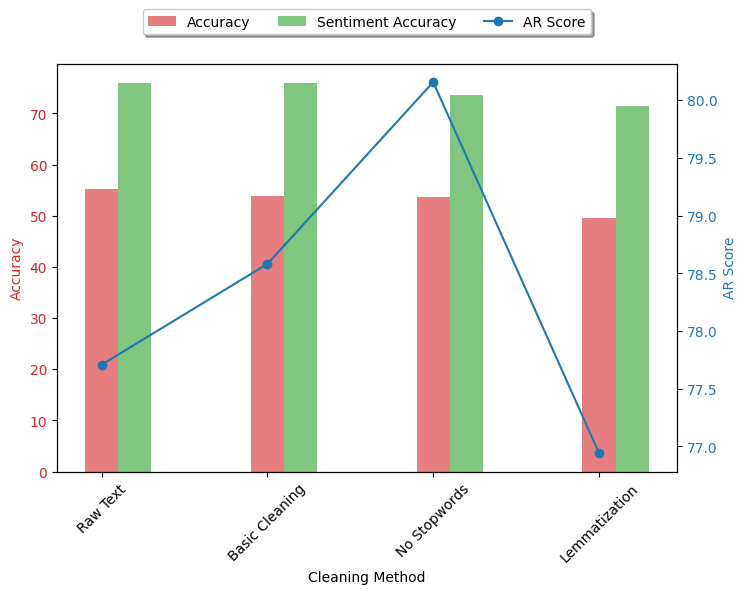

In [170]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]
sentiment_accuracies = [results[method][2] for method in methods]  # Assuming this is your sentiment accuracy data

x = range(len(methods))

fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plot Accuracy
color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)  # Rotate for better readability if needed

# Plot AR Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

# Adjust x position for sentiment_accuracy bars
x_sentiment = [i + 0.2 for i in x]  # Offset by 0.2

# Plot Sentiment Accuracy as bars
color = 'tab:green'  # Choose a different color for sentiment accuracy
ax1.bar(x_sentiment, sentiment_accuracies, color=color, alpha=0.6, width=0.2, align='center', label='Sentiment Accuracy')

# Legend
# Place the legend at the bottom of the plot
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=3)

# Adjust the bottom of the subplots to fit the legend
fig.subplots_adjust(bottom=0.2)

plt.show()

# BONUS - klasyfikacja sentymentu w mediach społecznościowych
Klasyfikator wyćwiczony na zbiorze opinii internetowych może zostać także wykorzystany w innych celach. Opinie w internecie na temat produktów mają podobną długość i wydźwięk emocjonalny jak wpisy na portalu X (dawniej Twitter). Spróbujmy zatem wykorzystać wcześniej wytrenowany przez nas model do określenia jak zmieniały się emocje (od negatywnych - "1 gwiazdka" do pozytywnych - "5 gwiazdek"). Naszą analizę przeprowadzimy na zbiorze wpisów z najpopularniejszych polskich kont z ostatnich 2 lat.

In [ ]:
# TODO